# Ampliaciones

Os pongo aquí algunas ideas que podrían aplicarse sobre el dataset, por si queréis ir un poco más lejos. Tened en cuenta que en un entorno real, estos pasos complican todo el pipeline de ETL, porque no se puede saber la distribución de todos los barrios a futuros. Es decir: habría que eliminar cualquier futura instancia que no perteneciera a los seleccionados en este momento, o bien agruparlos todos en una categoría "Otros", reduciendo la interpretabilidad.

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', None) # para mostrar todas las filas
pd.set_option('display.max_columns', None) # para mostrar todas las columnas

In [2]:
def remove_entries(df, n, col, element_name):
    nb_counts = Counter(df[col])
    inicial = df.shape[0]
    
    # Borramos elementos con menos de n registros
    for i in list(nb_counts):
        if nb_counts[i] < n:
            del nb_counts[i]
            df = df[df[col] != i]

    # Dibujamos
    tdf = pd.DataFrame.from_dict(nb_counts, orient='index').sort_values(by=0)
    ax = tdf.plot(kind='bar', figsize = (22,4), color = '#007A87', alpha = 0.85)
    ax.set_title(f"{element_name} por número de registros")
    ax.set_xlabel(f"{element_name}")
    ax.set_ylabel("# de registros")

    plt.show()

    print('Número de registros eliminado: ', inicial - df.shape[0])
    print(f"Número de {element_name}s:", len(nb_counts))
    
    return df

In [3]:
def calc_smooth_mean(df, by, on, m):
    # Compute the global mean
    mean = df[on].mean()

    # Compute the number of values and the mean of each group
    agg = df.groupby(by)[on].agg(['count', 'mean'])
    counts = agg['count']
    means = agg['mean']

    # Compute the "smoothed" means
    smooth = (counts * means + m * mean) / (counts + m)

    # Replace each value by the according smoothed mean
    return df[by].map(smooth)

In [4]:
df = pd.read_csv('./train.csv', sep=';', decimal='.')

not_useful_columns = [
    'ID', 'Listing Url', 'Scrape ID', 'Last Scraped', 'Thumbnail Url', 'Medium Url', 
    'Picture Url', 'XL Picture Url', 'Host ID', 'Host URL', 'Host Name', 
    'Host Thumbnail Url', 'Host Picture Url', 'Host Neighbourhood', 'Weekly Price', 
    'Monthly Price', 'Calendar Updated', 'Calendar last Scraped', 'First Review', 
    'Last Review', 'Reviews per Month', 'Geolocation', 'Calculated host listings count',
    'Host Listings Count', 'Host Total Listings Count'
]
somehow_useful_columns_but_droppable_anyway = ['Name', 'Summary', 'Space', 'Description',
       'Neighborhood Overview', 'Notes', 'Transit', 'Access', 'Interaction', 'House Rules',
       'Host Location', 'Host About'
]
columns_with_too_many_missing_values = [
    'Host Acceptance Rate', 'Square Feet', 'Has Availability', 'License', 'Jurisdiction Names'
]

df.drop(not_useful_columns, axis=1, inplace=True)
df.drop(somehow_useful_columns_but_droppable_anyway, axis=1, inplace=True)
df.drop(['Street', 'State', 'Market', 'Smart Location', 'Country', 'Zipcode'], axis=1, inplace=True)
df.drop(columns_with_too_many_missing_values, axis=1, inplace=True)

reviews = df.loc[: , "Review Scores Rating":"Review Scores Value"]
df['Average Review'] = reviews.mean(axis=1)

df.drop(['Availability 30', 'Availability 60', 'Availability 90', 'Review Scores Rating', 
         'Review Scores Accuracy', 'Review Scores Cleanliness', 'Review Scores Checkin',
       'Review Scores Communication', 'Review Scores Location', 'Review Scores Value',
        'Accommodates'], axis=1, inplace=True)

df = df[df['Price'] < 200]

df["Final Neighbourhood"] = df["Neighbourhood Group Cleansed"].fillna(df["Neighbourhood Cleansed"])
df.drop(["Neighbourhood", "Neighbourhood Group Cleansed", "Neighbourhood Cleansed"], axis=1, inplace=True)

df['Features'].fillna("", inplace=True) # rellenamos los huecos con cadenas vacías
df['Amenities'].fillna("", inplace=True)
df['Host Verifications'].fillna("", inplace=True)

df['Features'] = df['Features'].apply(lambda x: len(str(x).split(',')))
df['Amenities'] = df['Amenities'].apply(lambda x: len(str(x).split(',')))
df['Host Verifications'] = df['Host Verifications'].apply(lambda x: len(str(x).split(',')))

df['Host Since'].dropna(inplace=True)
df['Host Since'] = df['Host Since'].apply(lambda x: datetime.strptime(str(x),'%Y-%m-%d'))
df['Years Being Host'] = df['Host Since'].apply(lambda x: 2017 - x.year)
df.drop(['Host Since'], axis=1, inplace=True)

df["Host Response Time"].fillna(df["Host Response Time"].mode()[0], inplace=True)
df.drop(['Experiences Offered'], axis=1, inplace=True)
df.drop(['City', 'Country Code'], axis=1, inplace=True)

print(df.shape)

(11285, 26)


## Reducción de ruido

Esto está extraído casi textualmente del maravilloso análisis de [Dino Rodríguez](https://github.com/dino-rodriguez/optibnb). Vamos a analizar los barrios y seleccionar solo aquellos con un número de muestras representativo - arbitrariamente establecido en 200 (originalmente probé 100; el overfitting era grande). Primero vemos la situación actual:

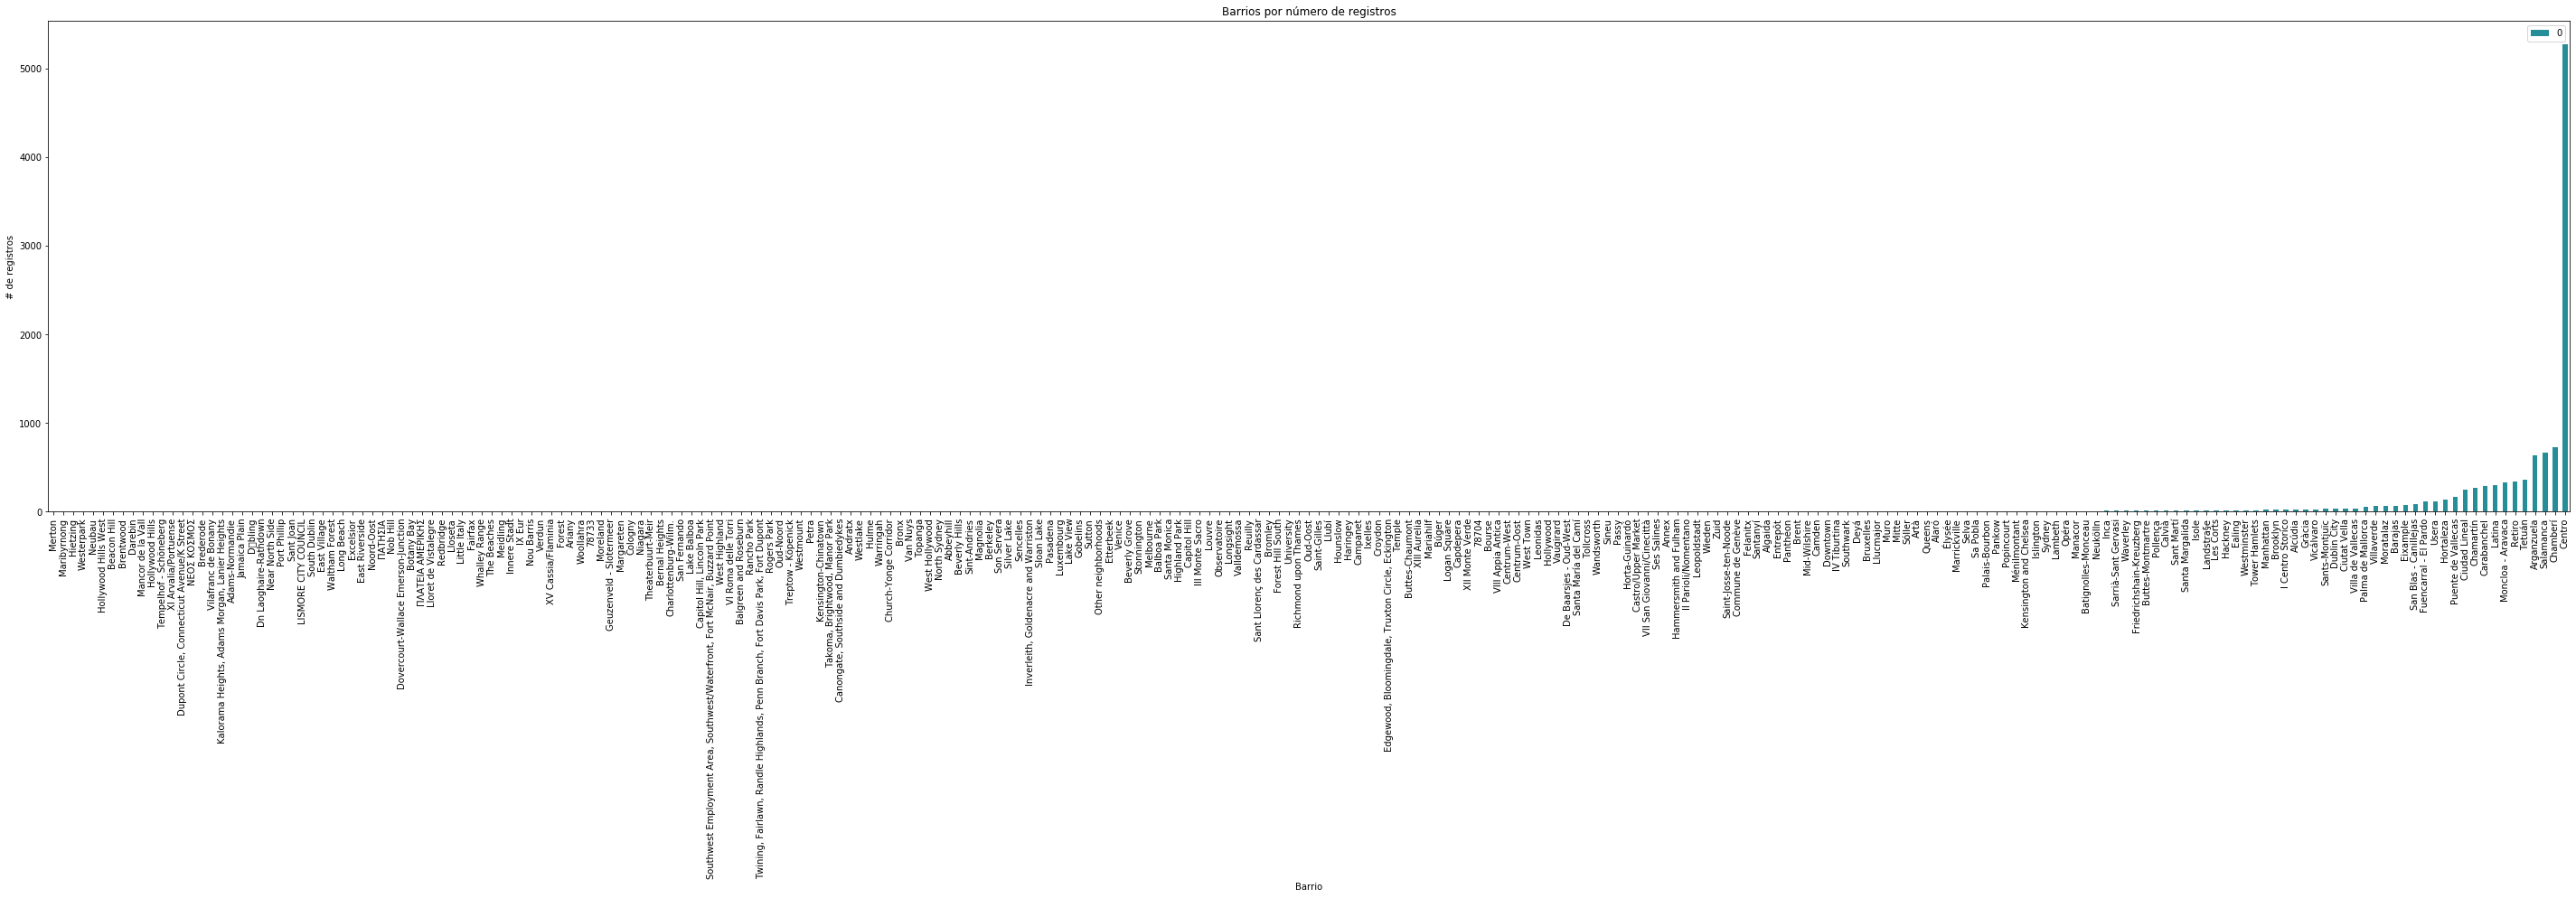

Número de barrios: 253


In [5]:
from collections import Counter

# Número de registros en cada barrio
nb_counts = Counter(df["Final Neighbourhood"])
tdf = pd.DataFrame.from_dict(nb_counts, orient='index').sort_values(by=0)

# Dibujamos
ax = tdf.plot(kind='bar', figsize = (50,10), color = '#007A87', alpha = 0.85)
ax.set_title("Barrios por número de registros")
ax.set_xlabel("Barrio")
ax.set_ylabel("# de registros")
plt.show()

print("Número de barrios:", len(nb_counts))

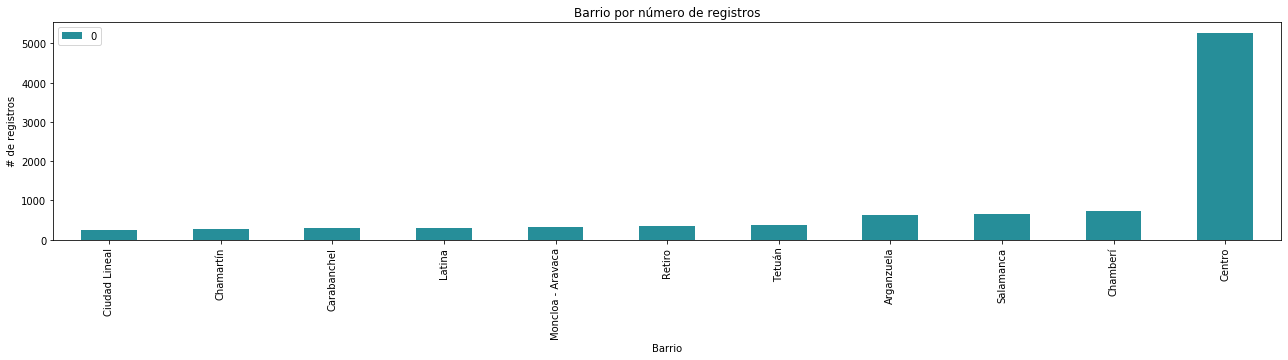

Número de registros eliminado:  1849
Número de Barrios: 11


In [6]:
df = remove_entries(df, 200, "Final Neighbourhood", "Barrio")

In [7]:
df["Property Type"].value_counts()

Apartment             7905
House                  642
Bed & Breakfast        232
Condominium            226
Loft                   201
Other                  132
Dorm                    32
Guesthouse              24
Hostel                  12
Chalet                   6
Boutique hotel           5
Townhouse                4
Serviced apartment       4
Casa particular          3
Earth House              2
Villa                    2
Tent                     1
Guest suite              1
Bungalow                 1
Camper/RV                1
Name: Property Type, dtype: int64

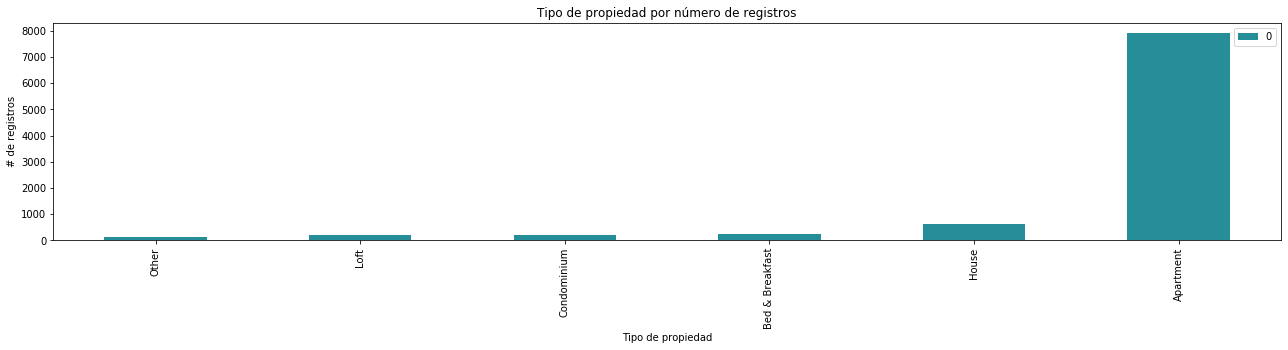

Número de registros eliminado:  98
Número de Tipo de propiedads: 6


In [8]:
# Eliminamos todos aquellos registros con menos de 100 valores, para reducir la dimensionalidad.
df = remove_entries(df, 100, "Property Type", "Tipo de propiedad")

In [9]:
df["Bed Type"].value_counts()

Real Bed         9120
Pull-out Sofa     172
Futon              31
Couch              11
Airbed              4
Name: Bed Type, dtype: int64

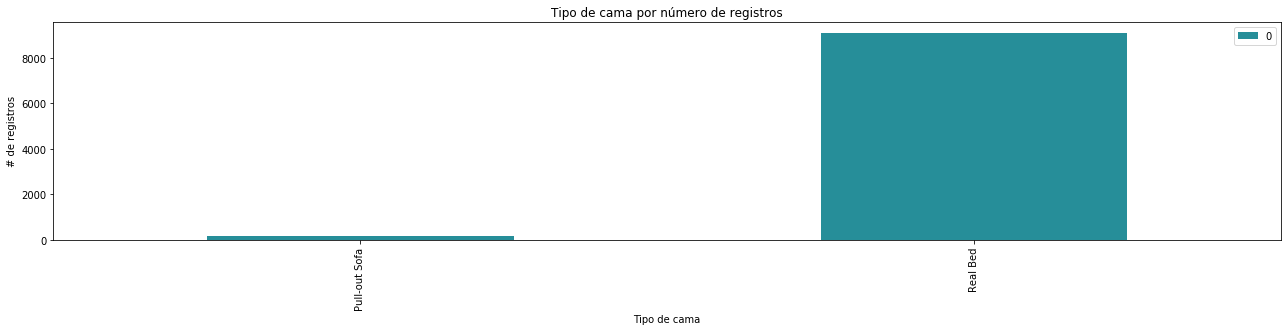

Número de registros eliminado:  46
Número de Tipo de camas: 2


In [10]:
# Eliminamos todos aquellos registros con menos de 100 valores, para reducir la dimensionalidad.
df = remove_entries(df, 100, "Bed Type", "Tipo de cama")

In [11]:
# Room type no tiene missing values y está decentemente balanceada
df["Room Type"].value_counts()

Entire home/apt    5740
Private room       3452
Shared room         100
Name: Room Type, dtype: int64

In [12]:
df["Cancellation Policy"].value_counts()

strict             3524
flexible           2897
moderate           2865
super_strict_60       4
super_strict_30       2
Name: Cancellation Policy, dtype: int64

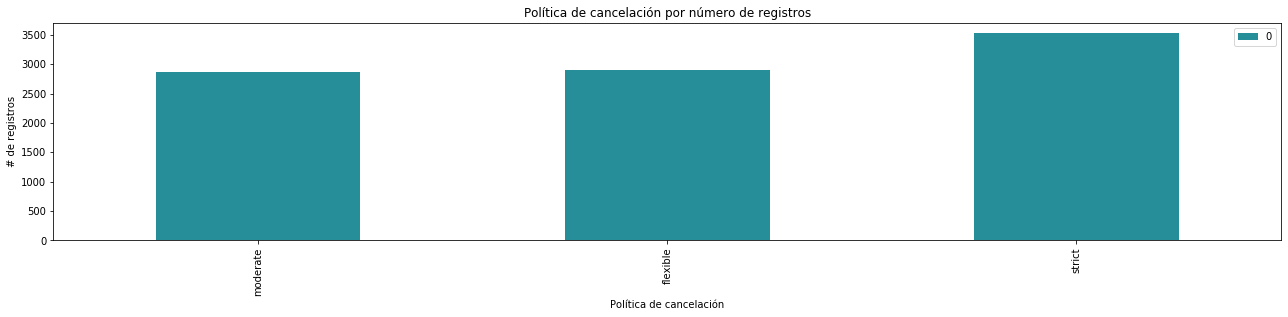

Número de registros eliminado:  6
Número de Política de cancelacións: 3


In [13]:
df = remove_entries(df, 100, "Cancellation Policy", "Política de cancelación")

In [14]:
categorical = ['Host Response Time', 'Property Type', 'Room Type', 'Bed Type', 'Cancellation Policy',
 'Final Neighbourhood'
]

for c in categorical:
    df[c] = calc_smooth_mean(df, by=c, on='Price', m=300)

cols = df.columns.tolist()
cols.insert(0, cols.pop(cols.index('Price')))
df = df[cols]

df.fillna(df.mean(), inplace=True)

df.shape

(9286, 26)